In [63]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import os
import requests

In [82]:
import pandas as pd
import anndata as ad
import sys
import numpy as np

## VIASH START
par = {
    'prediction': 'resources/results/op/op.ppcor.ppcor.prediction.h5ad',
    'evaluation_data': 'resources/grn_benchmark/evaluation_data/op_bulk.h5ad',
    'layer': 'lognorm',
    "max_n_links": 50000,
    'num_workers': 20
}
## VIASH END
try:
  sys.path.append(meta["resources_dir"])
except:
    meta = {
      "resources_dir":'src/metrics/recovery_2/',
      "util_dir":'src/utils'
    }
    sys.path.append(meta["resources_dir"])
    sys.path.append(meta["util_dir"])

from helper import main, calculate_tf_activity
from util import format_save_score, read_prediction

evaluation_adata = ad.read_h5ad(par['evaluation_data'])
net = read_prediction(par) # [source	target	weight]
tf_act = calculate_tf_activity(evaluation_adata, net, n_targets_t=10)
tf_act_random = calculate_tf_activity(evaluation_adata, net, n_targets_t=10, shuffle=True)

group = ['cell_type', 'perturbation']

Original net shape:  (50000, 3)
Network shape after cleaning: (50000, 3)
Network shape applying max_n_links: (50000, 3)


/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_53179/4009942528.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g_vals, df_group in df_tfs.groupby(group):
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_53179/4009942528.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g_vals, df_group in df_tfs.groupby(group):


Final score: 0.6904200956799025


In [84]:
aaa

NameError: name 'aaa' is not defined

In [ ]:
obs = ad.read_h5ad('resources/grn_benchmark/evaluation_data/300BCG_bulk.h5ad').obs
obs

,sum_by,pool,perturbation,cell_type,donor_id,time,is_control,split_group,age,qc_group,perturbation_type,batch,cell_count
307,_LPS_T3m_300BCG044_B_LPS_T3m_300BCG044_B,p4,LPS,B,300BCG044,T3m,False,LPS_T3m,23.0,LPS_T3m_300BCG044_B,chemical,b1,186
308,_LPS_T3m_300BCG044_CD4+ T_LPS_T3m_300BCG044_CD...,p4,LPS,CD4+ T,300BCG044,T3m,False,LPS_T3m,23.0,LPS_T3m_300BCG044_CD4+ T,chemical,b1,399
309,_LPS_T3m_300BCG044_CD8+ T_LPS_T3m_300BCG044_CD...,p4,LPS,CD8+ T,300BCG044,T3m,False,LPS_T3m,23.0,LPS_T3m_300BCG044_CD8+ T,chemical,b1,276
310,_LPS_T3m_300BCG044_HSP(T)_LPS_T3m_300BCG044_HS...,p4,LPS,HSP(T),300BCG044,T3m,False,LPS_T3m,23.0,LPS_T3m_300BCG044_HSP(T),chemical,b1,94
311,_LPS_T3m_300BCG044_Monocytes_LPS_T3m_300BCG044...,p4,LPS,Monocytes,300BCG044,T3m,False,LPS_T3m,23.0,LPS_T3m_300BCG044_Monocytes,chemical,b1,282
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,_RPMI_T3m_300BCG286_Monocytes_RPMI_T3m_300BCG2...,p8,RPMI,Monocytes,300BCG286,T3m,True,RPMI_T3m,20.0,RPMI_T3m_300BCG286_Monocytes,chemical,b1,345
1241,_RPMI_T3m_300BCG286_NK_RPMI_T3m_300BCG286_NK,p8,RPMI,NK,300BCG286,T3m,True,RPMI_T3m,20.0,RPMI_T3m_300BCG286_NK,chemical,b1,195
1242,_RPMI_T3m_300BCG286_Undefined_RPMI_T3m_300BCG2...,p8,RPMI,Undefined,300BCG286,T3m,True,RPMI_T3m,20.0,RPMI_T3m_300BCG286_Undefined,chemical,b1,18
1243,_RPMI_T3m_300BCG286_mDC_RPMI_T3m_300BCG286_mDC,p8,RPMI,mDC,300BCG286,T3m,True,RPMI_T3m,20.0,RPMI_T3m_300BCG286_mDC,chemical,b1,14


In [ ]:
obs.groupby(['donor_id', 'cell_type']).size()

/vol/tmp/users/jnourisa/ipykernel_579366/1581081284.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs.groupby(['donor_id', 'cell_type']).size()


donor_id   cell_type
300BCG044  B            2
           CD4+ T       2
           CD8+ T       2
           HSP(T)       2
           Monocytes    2
                       ..
300BCG286  NK           2
           Platelet     0
           Undefined    2
           mDC          1
           pDC          1
Length: 380, dtype: int64

In [ ]:
obs = ad.read_h5ad('resources/grn_benchmark/evaluation_data/ibd_bulk.h5ad').obs
obs.groupby(['donor_id', 'cell_type']).size()

/vol/tmp/users/jnourisa/ipykernel_579366/300964219.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs.groupby(['donor_id', 'cell_type']).size()


donor_id  cell_type
13        B            1
          CD4T         1
          CD8T         1
          MONO         1
          NK           1
                      ..
220       B            2
          CD4T         2
          CD8T         2
          MONO         2
          NK           2
Length: 185, dtype: int64

In [ ]:
ad.read_h5ad('../vcc/vcc_data/submissions/adata_submit_default_run.h5ad', backed='r')

AnnData object with n_obs × n_vars = 98927 × 18080 backed at '../vcc/vcc_data/submissions/adata_submit_default_run.h5ad'
    obs: 'target_gene'

/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:439: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


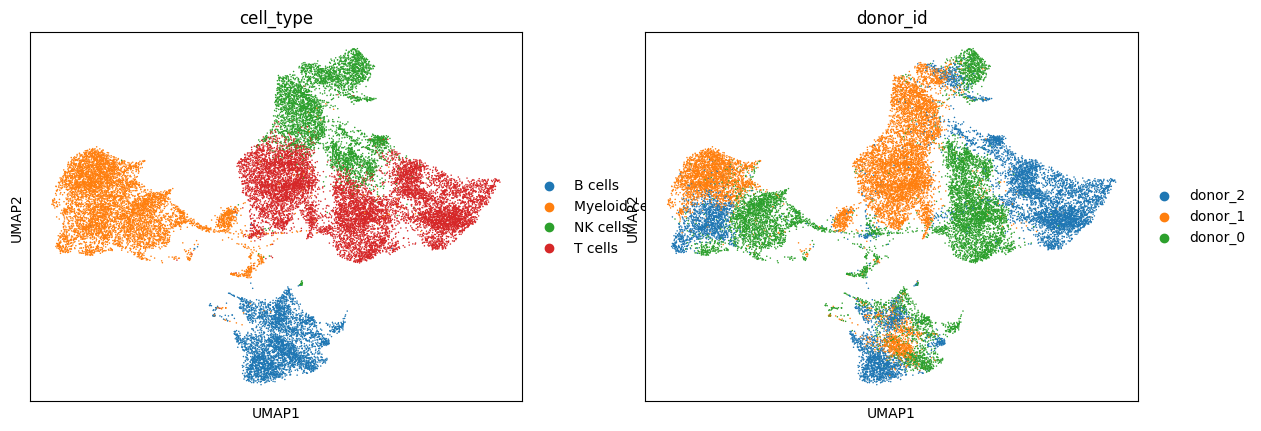

In [ ]:
import scanpy as sc

# Use the pearson residuals layer as input
sc.pp.pca(adata, use_highly_variable=False, n_comps=50, layer="pearson_residual")
sc.pp.neighbors(adata)

# Compute UMAP
sc.tl.umap(adata)

# Plot colored by cell type (or donor_id)
sc.pl.umap(adata, color=["cell_type", "donor_id"])

In [ ]:
net = pd.read_csv('output/dictys_test/net/Full/Subset1.tsv.gz', sep='\t', index_col=0)

In [ ]:
df_edges = net.reset_index().melt(id_vars=net.index.name or 'index', 
                                 var_name='target', 
                                 value_name='weight')
df_edges.rename(columns={net.index.name or 'index': 'source'}, inplace=True)



  source target    weight
0    AHR   A1BG  0.088030
1   ARNT   A1BG -0.077869
2   ATF1   A1BG  0.000000
3   ATF2   A1BG  0.000000
4   ATF3   A1BG -0.086774


In [ ]:
df_edges

,source,target,weight
0,AHR,A1BG,0.088030
1,ARNT,A1BG,-0.077869
2,ATF1,A1BG,0.000000
3,ATF2,A1BG,0.000000
4,ATF3,A1BG,-0.086774
...,...,...,...
1783177,ZFP82,ZZEF1,0.000000
1783178,ZFX,ZZEF1,0.052123
1783179,ZNF41,ZZEF1,0.000000
1783180,ZNF76,ZZEF1,0.050664


# Overlap of genes in inference and evaluation datasets

In [ ]:
for dataset in ['op', 'nakatake', 'norman', 'adamson', 'xaira_HCT116', 'xaira_HEK293T']:
    adata_inference = ad.read_h5ad(f'resources/grn_benchmark/inference_data/{dataset}_rna.h5ad', backed='r')
    adata_evaluation = ad.read_h5ad(f'resources/grn_benchmark/evaluation_data/{dataset}_bulk.h5ad', backed='r')

    inference_genes = adata_inference.var_names
    evaluation_genes = adata_evaluation.var_names

    common_genes = set(adata_inference.var_names).intersection(set(adata_evaluation.var_names))
    union_genes = set(adata_inference.var_names).union(set(adata_evaluation.var_names))
    only_evaluation = set(adata_evaluation.var_names) - set(adata_inference.var_names)

    print(f'{dataset}:', 
            f'Inference genes: {len(inference_genes)}',
            f'Evaluation genes: {len(evaluation_genes)}',
          f'Common genes: {len(common_genes)}',
          f'Union genes: {len(union_genes)}',
          f'Only evaluation genes: {len(only_evaluation)}')

op: Inference genes: 13595 Evaluation genes: 13595 Common genes: 13595 Union genes: 13595 Only evaluation genes: 0
nakatake: Inference genes: 25090 Evaluation genes: 25090 Common genes: 25090 Union genes: 25090 Only evaluation genes: 0
norman: Inference genes: 3459 Evaluation genes: 3511 Common genes: 3372 Union genes: 3598 Only evaluation genes: 139
adamson: Inference genes: 4786 Evaluation genes: 4932 Common genes: 4785 Union genes: 4933 Only evaluation genes: 147


OSError: Unable to synchronously open file (file signature not found)

# UMAP of perturbations

In [ ]:
!ls resources/extended_data/

adamson_bulk.h5ad  nakatake_bulk.h5ad  replogle_train_sc.h5ad
HCT116_bulk.h5ad   norman_bulk.h5ad    xaira_HCT116_bulk.h5ad
HCT116_sc.h5ad	   op_bulk.h5ad        xaira_HCT116_sc.h5ad
HEK293T_bulk.h5ad  replogle_bulk.h5ad  xaira_HEK293T_bulk.h5ad
HEK293T_sc.h5ad    replogle_sc.h5ad    xaira_HEK293T_sc.h5ad


Processing dataset: xaira_HCT116


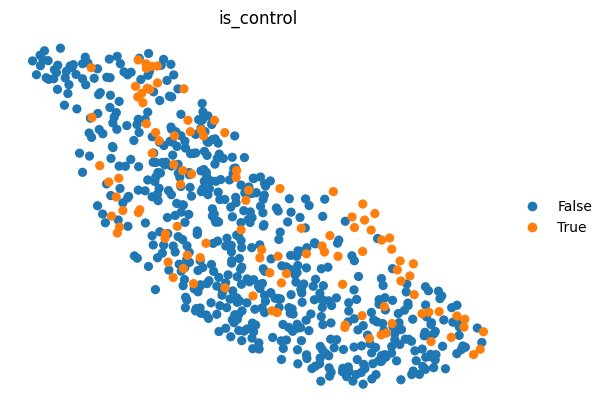

Processing dataset: xaira_HEK293T


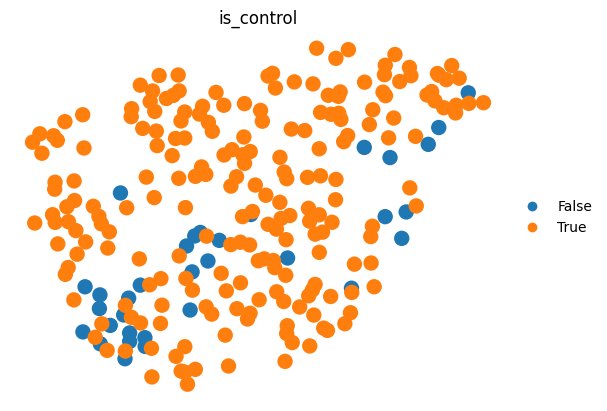

Processing dataset: replogle


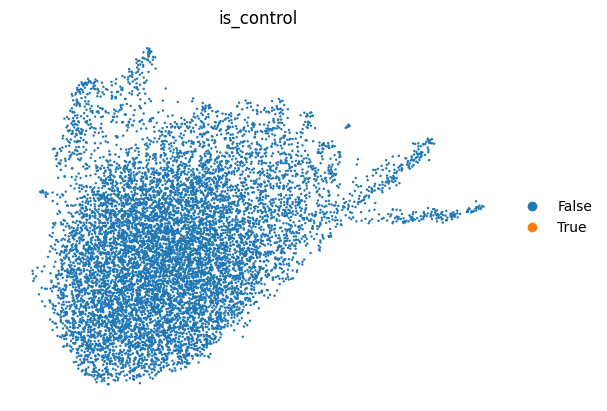

In [ ]:
for dataset in ['xaira_HCT116', 'xaira_HEK293T', 'replogle']:
    print(f'Processing dataset: {dataset}')
    adata = ad.read_h5ad(f'resources/extended_data/{dataset}_bulk.h5ad')

    adata.X = adata.layers['lognorm']
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    sc.pl.umap(adata,
        color=['is_control'],
        frameon=False,
        wspace=0.5)

# Assemble the results from differnet runs

In [ ]:
!rm -r resources/results/all_main/

In [ ]:
import os
import shutil
import yaml
from pathlib import Path
from collections import OrderedDict

base_dir = 'resources/results/'
save_dir = 'resources/results/all_main/'
runs = ['op', 'nakatake', 'norman', 'replogle', 'adamson']

os.makedirs(save_dir, exist_ok=True)

# 1. Copy one version of the identical files
identical_files = ['method_configs.yaml', 'metric_configs.yaml']
for fname in identical_files:
    src = os.path.join(base_dir, f'{runs[0]}_run', fname)
    dst = os.path.join(save_dir, fname)
    shutil.copyfile(src, dst)
    print(f"Copied identical file: {fname}")

# 2. Merge dataset_uns.yaml by appending all contents
merged_uns = []
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'dataset_uns.yaml')

    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        merged_uns.extend(data)
        
with open(os.path.join(save_dir, 'dataset_uns.yaml'), 'w') as f:
    yaml.dump(merged_uns, f)
print("Merged: dataset_uns.yaml")

# 3. Merge score_uns.yaml similarly
merged_scores = []
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'score_uns.yaml')

    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        # - remove those with missing (because of the metric)
        data = [d for d in data if d is not None and 'missing' not in str(d)]
        
        # print(str(data[0]))
        # aa
        # missing
        if data:
            if isinstance(data, dict):
                merged_scores.append(data)
            elif isinstance(data, list):
                merged_scores.extend(data)
            else:
                print(f"Unexpected format in {path}: {type(data)}")

with open(os.path.join(save_dir, 'score_uns.yaml'), 'w') as f:
    yaml.dump(merged_scores, f)
print("Merged: score_uns.yaml")

# 4. Merge trace.txt with deduplication
seen_lines = OrderedDict()
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'trace.txt')
    
    with open(path, 'r') as f:
        for line in f:
            seen_lines[line] = None

with open(os.path.join(save_dir, 'trace.txt'), 'w') as f:
    for line in seen_lines.keys():
        f.write(line)
df = pd.read_csv(os.path.join(save_dir, 'trace.txt'), sep='\t')
df = df.drop_duplicates(subset=['name'])
df.to_csv(os.path.join(save_dir, 'trace.txt'), sep='\t')
print("Merged: trace.txt (duplicates removed)")

# 5. Copy other unknown files/directories
all_known = set(identical_files + ['dataset_uns.yaml', 'score_uns.yaml', 'trace.txt'])

for run in runs:
    run_dir = Path(base_dir) / f'{run}_run'
    for file_path in run_dir.iterdir():
        if file_path.name in all_known:
            continue

        dest_path = Path(save_dir) / file_path.name

        if dest_path.exists():
            dest_path = Path(save_dir) / f"{file_path.stem}_{run}{file_path.suffix}"

        if file_path.is_file():
            shutil.copyfile(file_path, dest_path)
            print(f"Copied unique file: {file_path.name} → {dest_path.name}")
        elif file_path.is_dir():
            shutil.copytree(file_path, dest_path)
            print(f"Copied unique directory: {file_path.name} → {dest_path.name}")

Copied identical file: method_configs.yaml
Copied identical file: metric_configs.yaml
Merged: dataset_uns.yaml
Merged: score_uns.yaml
Merged: trace.txt (duplicates removed)
Copied unique file: state.yaml → state.yaml
Copied unique file: op_.celloracle.celloracle.prediction.h5ad → op_.celloracle.celloracle.prediction.h5ad
Copied unique file: scplus_mdata.h5mu.2DAaAA8E → scplus_mdata.h5mu.2DAaAA8E
Copied unique file: op_.negative_control.negative_control.prediction.h5ad → op_.negative_control.negative_control.prediction.h5ad
Copied unique file: op_.scenicplus.scenicplus.prediction.h5ad → op_.scenicplus.scenicplus.prediction.h5ad
Copied unique file: op_.portia.portia.prediction.h5ad → op_.portia.portia.prediction.h5ad
Copied unique file: op_.granie.granie.prediction.h5ad → op_.granie.granie.prediction.h5ad
Copied unique file: op_.scprint.scprint.prediction.h5ad → op_.scprint.scprint.prediction.h5ad
Copied unique file: op_.pearson_corr.pearson_corr.prediction.h5ad → op_.pearson_corr.pearso

# Rename grnboost2 to grnboost

In [ ]:
import os

target_dir = 'resources/results/all_main'

for root, _, files in os.walk(target_dir):
    for fname in files:
        fpath = os.path.join(root, fname)

        # Skip binary files (optional safety)
        try:
            with open(fpath, 'r', encoding='utf-8') as f:
                content = f.read()
        except UnicodeDecodeError:
            continue  # likely a binary file, skip it

        if 'grnboost2' in content:
            content = content.replace('grnboost2', 'grnboost')
            with open(fpath, 'w', encoding='utf-8') as f:
                f.write(content)
            print(f"Updated: {fpath}")

Updated: resources/results/all_main/trace.txt
Updated: resources/results/all_main/method_configs.yaml
Updated: resources/results/all_main/score_uns.yaml


## Create Nakatake test

In [ ]:
adata = ad.read_h5ad('resources/grn_benchmark/inference_data/nakatake_rna.h5ad')
# Sample 100 cells
sampled_cells = adata.obs.sample(n=100, random_state=0).index

# Sample 2000 genes
sampled_genes = adata.var.sample(n=2000, random_state=0).index

# Subset the AnnData object
adata_subset = adata[sampled_cells, sampled_genes].copy()
adata_subset.write('resources_test/grn_benchmark/inference_data/nakatake_rna.h5ad')

In [ ]:
adata = ad.read_h5ad('resources/grn_benchmark/evaluation_data/nakatake_bulk.h5ad')
# Sample 100 cells
sampled_cells = adata.obs.sample(n=100, random_state=0).index

# Sample 2000 genes
sampled_genes = adata.var.sample(n=2000, random_state=0).index

# Subset the AnnData object
adata_subset = adata[sampled_cells, sampled_genes].copy()
adata_subset.write('resources_test/grn_benchmark/evaluation_data/nakatake_bulk.h5ad')